In [27]:
import json
import pandas as pd
import glob

import sys

import random
import tomotopy as tp
sys.path.append("C:/Users/yuuta/Documents/fashion")

from utils.util import filter_basic_items, is_target_category
from utils.util import calc_roc_auc
from utils.infer import topic_model_infer
from utils.util import open_json

In [28]:
import importlib
import utils
importlib.reload(utils.infer)

c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yuuta\anaconda3\envs\fashion\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<module 'utils.infer' from 'C:\\Users/yuuta/Documents/fashion\\utils\\infer.py'>

In [29]:
negative_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates/**.json"
    # "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates_random/**.json"
    # "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
    # negative_coordinates_random
)
positive_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
)

In [30]:
with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_test.json",
    encoding="shift-jis"
) as f:
    to_attributes = json.load(f)

with open(
    "C:/Users/yuuta/Documents/fashion/data/attributes_train.json",
    encoding="shift-jis"
) as f:
    to_attributes_2 = json.load(f)

to_attributes = {**to_attributes, **to_attributes_2}



In [31]:
# mdl = tp.LDAModel.load(
#     "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/lda.bin"
# )
# mdl = tp.CTModel.load(
#     "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/ctm.bin"
# )
mdl = tp.MGLDAModel.load(
    "C:/Users/yuuta/Documents/fashion/model_learning/topic_model/models/MGLDA.bin"
)

In [32]:
for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

Top 10 words of topic #0
[('tops_Silk', 0.053122829645872116), ('bottoms_Blue', 0.0451885461807251), ('tops_White', 0.0429576113820076), ('shoes_geo', 0.038999803364276886), ('tops_Denim', 0.03167225793004036), ('shoes_plain', 0.030953506007790565), ('shoes_Black', 0.03044944442808628), ('tops_plainbottoms_Silk', 0.023476608097553253), ('tops_plainbottoms_Denim', 0.021777737885713577), ('tops_Black', 0.019621478393673897)]
Top 10 words of topic #1
[('tops_Silk', 0.07015150040388107), ('tops_White', 0.06482736766338348), ('tops_Blue', 0.05684599280357361), ('tops_Black', 0.04528943449258804), ('tops_Denim', 0.04362745210528374), ('shoes_geo', 0.04144369065761566), ('shoes_Black', 0.035201601684093475), ('shoes_plain', 0.030070722103118896), ('tops_plaintops_Silk', 0.028688959777355194), ('tops_Navy', 0.02839907817542553)]
Top 10 words of topic #2
[('bottoms_Denim', 0.06662385910749435), ('bottoms_Silk', 0.06299417465925217), ('shoes_geo', 0.05615757033228874), ('bottoms_Blue', 0.0498468

In [33]:
print(len(negative_path), len(positive_path))

10000 53072


In [34]:
negative_path = random.sample(negative_path, 10000)
positive_path = random.sample(positive_path, 10000)

In [35]:
topic_model_score = []
labels = []

# ポジティブなもの
positive_ave = 0
for fp in positive_path:
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    # items = list(filter(is_target_category, json_dict["items"]))
    attributes = []
    if len(items) != 3:
        continue
    for item in items:
        try:
            itemId = str(item["itemId"])
        except Exception as e:
            print(fp, " : ", e)
            continue
        attr = to_attributes[itemId]
        attributes += attr
    score = topic_model_infer(mdl, attributes)
    topic_model_score.append(score)
    labels.append(0)

In [36]:
# ネガティブなもの
for fp in negative_path:
    json_dict = pd.read_json(fp, encoding="shift-jis")
    # items = list(filter(is_target_category, json_dict["items"]))
    items = filter_basic_items(json_dict["items"])
    attributes = []
    if len(items) != 3:
        continue
    for item in items:
        try:
            itemId = str(item["itemId"])
        except Exception as e:
            print(fp, " : ", e)
            continue
        attr = to_attributes[itemId]
        attributes += attr
    if len(attributes) != 9:
        continue
    score = topic_model_infer(mdl, attributes)
    topic_model_score.append(score)
    labels.append(1)

In [37]:
print(sum(topic_model_score[:sum(labels)]) / sum(labels), sum(topic_model_score[sum(labels):]) / (len(labels) - sum(labels)))

-41.7883601770401 -41.866571821243504


In [38]:
print(sum(labels))

10000


0.4977785437487252


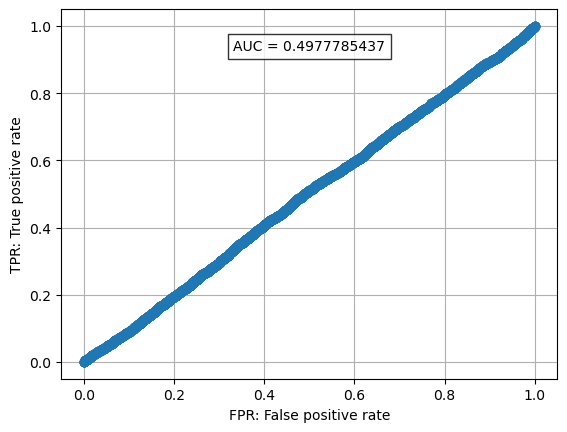

In [39]:
# t_auc = calc_roc_auc(labels, topic_model_score, "topic_model")
t_auc = calc_roc_auc(labels, topic_model_score, "ctm_random")

# print(t_auc, p_auc, len(labels))
print(t_auc)